In [1]:
import sys
sys.path.append("../") 

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, data_home='../data',cache=True,as_frame=False)
X=X/255.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

In [4]:
import numpy as np
from hamiltonian import utils

num_examples,num_inputs=X_train.shape
num_outputs=len(np.unique(y_train))

#y_train=utils.one_hot(y_train,num_outputs)
#y_test=utils.one_hot(y_test,num_outputs)

In [5]:
y_train=np.int32(y_train)
y_test=np.int32(y_test)

In [6]:
import mxnet as mx
from mxnet import nd, autograd, gluon


model_ctx=mx.cpu()
par={'weights':nd.random_normal(shape=(num_inputs,num_outputs),ctx=model_ctx),'bias':nd.random_normal(shape=num_outputs,ctx=model_ctx)}
hyper={'alpha':10.}


# Stochastic Gradient Descent

In [16]:
from hamiltonian.inference.sgd import sgd
from hamiltonian.models.softmax import softmax

model=softmax(hyper,ctx=model_ctx)
inference=sgd(model,par,step_size=0.05,ctx=model_ctx)

In [15]:
import importlib
import hamiltonian
importlib.reload(hamiltonian.models.softmax)
importlib.reload(hamiltonian.inference.sgd)

<module 'hamiltonian.inference.sgd' from '../hamiltonian/inference/sgd.py'>

In [29]:
par,loss=inference.fit(epochs=10,batch_size=64,X_train=X_train,y_train=y_train,verbose=False)

100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


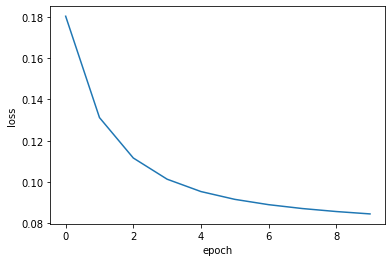

In [30]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [20]:
par2,loss2=inference.fit_gluon(epochs=10,batch_size=64,X_train=X_train,y_train=y_train,verbose=False)

100%|██████████| 10/10 [00:50<00:00,  5.01s/it]


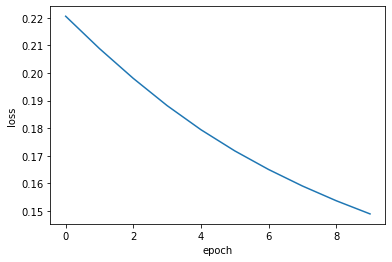

In [21]:
import matplotlib.pyplot as plt

plt.plot(loss2)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [31]:
y_pred=model.predict(par,nd.array(X_test,ctx=model_ctx))

In [32]:
samples=[]
for _ in range(100):
    samples.append(y_pred.sample().asnumpy())

In [33]:
samples=np.asarray(samples)

In [34]:
samples.shape

(100, 14000)

In [35]:
y_hat=np.quantile(samples,.5,axis=0)

In [36]:
from sklearn.metrics import classification_report

print(classification_report(np.int32(y_test),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1350
           1       0.90      0.89      0.89      1540
           2       0.76      0.75      0.75      1377
           3       0.73      0.76      0.75      1488
           4       0.76      0.77      0.76      1381
           5       0.65      0.59      0.62      1227
           6       0.80      0.84      0.82      1377
           7       0.77      0.79      0.78      1487
           8       0.62      0.67      0.65      1355
           9       0.70      0.64      0.67      1418

    accuracy                           0.76     14000
   macro avg       0.76      0.76      0.76     14000
weighted avg       0.76      0.76      0.76     14000



In [28]:
X_batch=nd.array(X_train[:32],ctx=model_ctx)
y_batch=nd.array(y_train[:32],ctx=model_ctx)

In [29]:
like=model.negative_log_likelihood(par,X_train=X_batch,y_train=y_batch)
prior=model.negative_log_prior(par)

# Stochastic Gradient Langevin Dynamics

In [34]:
par={'weights':nd.random_normal(shape=(num_inputs,num_outputs),ctx=model_ctx),
     'bias':nd.random_normal(shape=num_outputs,ctx=model_ctx)}
hyper={'alpha':10.}

In [35]:
from hamiltonian.inference.sgld import sgld
from hamiltonian.models.softmax import softmax

model=softmax(hyper,ctx=model_ctx)
inference=sgld(model,par,step_size=0.05,ctx=model_ctx)

In [36]:
import importlib
import hamiltonian
importlib.reload(hamiltonian.models.softmax)
importlib.reload(hamiltonian.inference.sgld)

<module 'hamiltonian.inference.sgld' from '../hamiltonian/inference/sgld.py'>

In [54]:
par,loss,posterior_samples=inference.fit(epochs=5,batch_size=64,
                             X_train=X_train,y_train=y_train,
                             verbose=False)

100%|██████████| 5/5 [00:30<00:00,  6.07s/it]


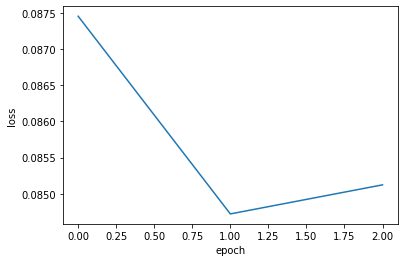

In [38]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [51]:
y_pred=model.predict(par,nd.array(X_test,ctx=model_ctx))

In [52]:
from sklearn.metrics import classification_report

samples=[]
for _ in range(100):
    samples.append(y_pred.sample().asnumpy())
samples=np.asarray(samples)
y_hat=np.quantile(samples,.5,axis=0)

print(classification_report(np.int32(y_test),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1350
           1       0.94      0.93      0.93      1540
           2       0.87      0.82      0.85      1377
           3       0.86      0.84      0.85      1488
           4       0.86      0.87      0.86      1381
           5       0.84      0.75      0.79      1227
           6       0.89      0.93      0.91      1377
           7       0.90      0.87      0.88      1487
           8       0.74      0.83      0.78      1355
           9       0.81      0.83      0.82      1418

    accuracy                           0.86     14000
   macro avg       0.86      0.86      0.86     14000
weighted avg       0.86      0.86      0.86     14000



# Bayes by Backprop

In [88]:
par={'weights':nd.random_normal(shape=(num_inputs,num_outputs),ctx=model_ctx),
     'bias':nd.random_normal(shape=num_outputs,ctx=model_ctx)}
hyper={'alpha':10.}

In [89]:
from hamiltonian.inference.bbb import bbb
from hamiltonian.models.softmax import softmax

model=softmax(hyper,ctx=model_ctx)
inference=bbb(model,par,step_size=0.05,ctx=model_ctx)

In [90]:
import importlib
import hamiltonian
importlib.reload(hamiltonian.models.softmax)
importlib.reload(hamiltonian.inference.bbb)

<module 'hamiltonian.inference.bbb' from '../hamiltonian/inference/bbb.py'>

In [91]:
par,loss=inference.fit(epochs=10,batch_size=64,
                             X_train=X_train,y_train=y_train,
                             verbose=True)

 10%|█         | 1/10 [00:02<00:25,  2.89s/it]

loss: 0.2513


 20%|██        | 2/10 [00:05<00:23,  2.88s/it]

loss: 0.2277


 30%|███       | 3/10 [00:08<00:20,  2.86s/it]

loss: 0.2041


 40%|████      | 4/10 [00:11<00:17,  2.86s/it]

loss: 0.1837


 50%|█████     | 5/10 [00:14<00:14,  2.86s/it]

loss: 0.1693


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

loss: 0.1583


 70%|███████   | 7/10 [00:20<00:08,  2.85s/it]

loss: 0.1485


 80%|████████  | 8/10 [00:22<00:05,  2.85s/it]

loss: 0.1414


 90%|█████████ | 9/10 [00:25<00:02,  2.85s/it]

loss: 0.1354


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

loss: 0.1311


In [92]:
loss

array([0.25126649, 0.22772226, 0.20409858, 0.18373182, 0.1692891 ,
       0.15830716, 0.14847917, 0.14137107, 0.13541743, 0.13113058])

# Posterior Diagnostics

In [55]:
import arviz as az

In [56]:
np.expand_dims(np.asarray([posterior_samples['bias'][0].asnumpy() for sample in posterior_samples['bias']]),0).shape

(1, 5, 10)

In [57]:
posterior_samples_numpy=dict()

for var in posterior_samples.keys():
    posterior_samples_numpy.update(
        {var:np.expand_dims(np.asarray(
            [sample.asnumpy() for sample in posterior_samples[var]]),0)
        })


In [58]:
posterior_samples_numpy['weights'].shape

(1, 5, 784, 10)

In [59]:
dataset = az.convert_to_inference_data(posterior_samples_numpy)

In [60]:
ess=az.ess(dataset)

In [61]:
ess

<xarray.Dataset>
Dimensions:        (bias_dim_0: 10, weights_dim_0: 784, weights_dim_1: 10)
Coordinates:
  * weights_dim_0  (weights_dim_0) int64 0 1 2 3 4 5 ... 778 779 780 781 782 783
  * weights_dim_1  (weights_dim_1) int64 0 1 2 3 4 5 6 7 8 9
  * bias_dim_0     (bias_dim_0) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    weights        (weights_dim_0, weights_dim_1) float64 4.0 4.0 ... 4.0 4.0
    bias           (bias_dim_0) float64 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0

In [62]:
az.summary(dataset)

arviz - WARNING - Shape validation failed: input_shape: (1, 5), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"weights[0,0]",1.862,0.0,1.862,1.862,0.0,0.0,4.0,4.0,NaN
"weights[0,1]",-2.258,0.0,-2.258,-2.258,0.0,0.0,4.0,4.0,NaN
"weights[0,2]",-1.389,0.0,-1.389,-1.389,0.0,0.0,4.0,4.0,NaN
"weights[0,3]",-1.668,0.0,-1.668,-1.668,0.0,0.0,4.0,4.0,NaN
"weights[0,4]",-1.602,0.0,-1.602,-1.602,0.0,0.0,4.0,4.0,NaN
...,...,...,...,...,...,...,...,...,...
bias[5],0.509,0.0,0.509,0.509,0.0,0.0,4.0,4.0,NaN
bias[6],-0.058,0.0,-0.058,-0.058,0.0,0.0,4.0,4.0,NaN
bias[7],0.362,0.0,0.362,0.362,0.0,0.0,4.0,4.0,NaN
bias[8],-0.409,0.0,-0.409,-0.409,0.0,0.0,4.0,4.0,NaN


In [63]:
784*10+10

7850